In [2]:
import sys
sys.path.append('/home/piotr/projects/twitter/src')
import pandas as pd
from twitter_models.polarization import ModelPolarization
from tqdm import trange
import gc
from matplotlib import pyplot as plt
import numpy as np
import json
from statsmodels.graphics.tsaplots import plot_acf
import collections
import pickle
import itertools
import os
import random
from scipy.sparse import csr_matrix

## Things to consider:
- treatment of zeros produced when calculating leave-out estimators
- how should be the randomization performed - randomize globally or for at each iteration (i.e. for each time *t*). For now, globally

### Run model

In [21]:
import warnings
warnings.filterwarnings('ignore')
def run_models(N, retweets = True, randomized = False, 
               conf_int = 100, aggregate = True, keyword = None):
    
    
    if randomized:
        random.seed(1234)
        #get randomized ids
        gov = pickle.load(open("data/sample/gov_ids.pickle","rb"))[:5000]
        opp = pickle.load(open("data/sample/opp_ids.pickle","rb"))[:5000]
        allids = gov + opp
        shuffled = dict()
        while allids:
            shuffled[allids.pop(random.randint(0,len(allids)-1))] = "government"
            shuffled[allids.pop(random.randint(0,len(allids)-1))] = "opposition"
    
    
    results = {"date":[], "true":{"plugin":[], "leaveout":[]},
                          "random":{"plugin":[], "leaveout":[]}}
    date = pd.Period('2020-02-22', 'D') 
    
    for _ in trange(N):
        date += 1
        datestr = date.strftime("%Y_%m_%d")
        results["date"].append(datestr)
        
        
        path = "data/clean/gov_tweets_" + datestr + ".csv"
        gov_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        gov_data["source"] = "government"
        gov_data = gov_data.loc[gov_data.created_at.notna()]
        gov_data = gov_data.drop(columns = ["index"])
        
        
        path = "data/clean/opp_tweets_" + datestr + ".csv"
        opp_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        opp_data["source"] = "opposition"
        opp_data = opp_data.loc[opp_data.created_at.notna()]
        opp_data = opp_data.drop(columns = ["index"])

        #merge the datasets
        tweet_data = pd.concat([gov_data, opp_data], axis = 0)
        del(gov_data)
        del(opp_data)
        gc.collect()
        
        #drop any problematic values
        tweet_data.dropna(subset = ["source","preprocessed","user-id_str"], inplace = True)
        
        #filter out retweets
        if not retweets:
            tweet_data = tweet_data.loc[tweet_data["retweet"] == "No"]
        
        #filter on specific keywords
        if keyword is not None:
            tweet_data = tweet_data.loc[tweet_data["preprocessed"].str.contains(keyword)]
        
        
        
        
        #get party, user id and text
        parties = tweet_data["source"].tolist()
        users = tweet_data["user-id_str"].tolist()
        tweets = tweet_data["preprocessed"].tolist()
        tweets = [elem.lower() for elem in tweets]
        
        
        if aggregate:
        
            #TRUE ESTIMATES
            model = ModelPolarization(parties, users, tweets)
            results["true"]["plugin"].append(model.estimate(conf_int = conf_int, leave_out = False))
            results["true"]["leaveout"].append(model.estimate(conf_int = conf_int, leave_out = True))

            if randomized:
                #RANDOMIZED ESTIMATES
                #get randomized users
                random_parties = [shuffled[str(user)] for user in users]
                model = ModelPolarization(random_parties, users, tweets)
                results["random"]["plugin"].append(model.estimate(conf_int = conf_int, leave_out = False))
                results["random"]["leaveout"].append(model.estimate(conf_int = conf_int, leave_out = True))
        else:
            model = ModelPolarization(parties, users, tweets)
            scores = model.polarization(model.counts, leave_out = True, absolute = False)
            results["true"]["leaveout"].append(dict(zip(model.counts.keys(), scores)))
        
    return results

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

### First, the leave-out estimator of partisanship is computed for data excluding re-tweets:

In [3]:
if os.path.isfile("analysis/polarization_results_no_retweets.json":
    results = json.load(open("analysis/polarization_results_no_retweets.json","r"))
else:
    results = run_models(70, retweets = False, randomized = True)
    json.dump(results, open("analysis/polarization_results_no_retweets.json", "w"))

100%|██████████| 70/70 [46:37<00:00, 39.96s/it]


#### Compute confidence intervals:

In [72]:
date = results["date"]
stats = {"true":dict(), "random":dict()}
for type in stats:
    
    #sample sizes for each time step
    sample_sizes = np.array([elem['n']['government'] + elem['n']['opposition'] for elem in results[type]['leaveout']])
    subsample_sizes = np.array([[elem['n']['government'] + elem['n']['opposition'] for elem in t['samples']] for t in results[type]['leaveout']])

    #sample estimates for each time step
    sample_estimates = np.array([elem['point'] for elem in results[type]['leaveout']])
    subsample_estimates = np.array([[elem['point'] for elem in t['samples']] for t in results[type]['leaveout']])

    #Qkt - for each subsample at each timestep - deviation of subsample from the mean, normalized by sqrt of the subsample's SD
    Q_kt = np.sqrt(subsample_sizes) * (subsample_estimates - 0.01 * np.sum(subsample_estimates, axis = 1)[:,np.newaxis])

    #lower ci
    stats[type]['lower_ci'] = sample_estimates - np.partition(Q_kt, 90, axis = 1)[:,90]/np.sqrt(sample_sizes)
    
    #upper ci
    stats[type]['upper_ci'] = sample_estimates - np.partition(Q_kt, 10, axis = 1)[:,10]/np.sqrt(sample_sizes) 
    
    #estimates
    stats[type]['estimates'] = sample_estimates
    

#### Plot:

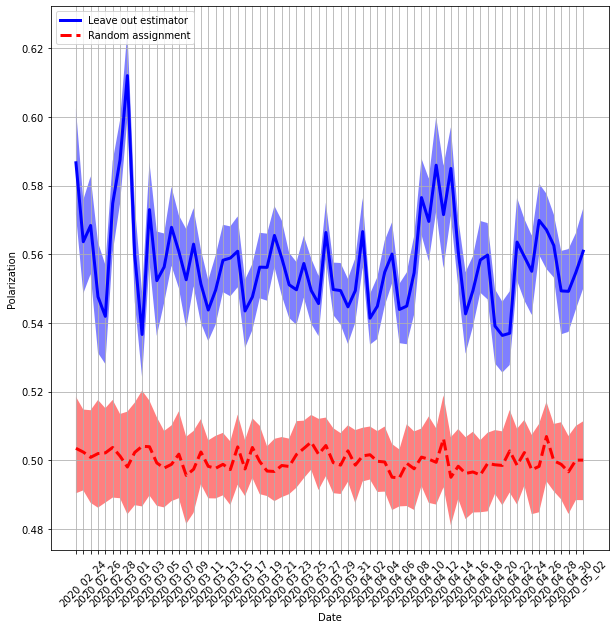

In [83]:
fig, ax = plt.subplots(1,figsize = (10,10))
ax.plot(date, stats['true']['estimates'], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date, stats['random']['estimates'], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date, stats['true']['upper_ci'], stats['true']['lower_ci'], facecolor='blue', alpha=0.5)
ax.fill_between(date, stats['random']['upper_ci'], stats['random']['lower_ci'], facecolor='red', alpha=0.5)
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()

In [12]:
if os.path.isfile("analysis/polarization_results_retweets.json"):
    results = json.load(open("analysis/polarization_results_retweets.json","r"))
else:
    results = run_models(70, retweets = True, randomized = True)
    json.dump(results, open("analysis/polarization_results_retweets.json", "w"))

In [15]:
date = results["date"]
stats = {"true":dict(), "random":dict()}
for type in stats:
    
    #sample sizes for each time step
    sample_sizes = np.array([elem['n']['government'] + elem['n']['opposition'] for elem in results[type]['leaveout']])
    subsample_sizes = np.array([[elem['n']['government'] + elem['n']['opposition'] for elem in t['samples']] for t in results[type]['leaveout']])

    #sample estimates for each time step
    sample_estimates = np.array([elem['point'] for elem in results[type]['leaveout']])
    subsample_estimates = np.array([[elem['point'] for elem in t['samples']] for t in results[type]['leaveout']])

    #Qkt - for each subsample at each timestep - deviation of subsample from the mean, normalized by sqrt of the subsample's SD
    Q_kt = np.sqrt(subsample_sizes) * (subsample_estimates - 0.01 * np.sum(subsample_estimates, axis = 1)[:,np.newaxis])

    #lower ci
    stats[type]['lower_ci'] = sample_estimates - np.partition(Q_kt, 90, axis = 1)[:,90]/np.sqrt(sample_sizes)
    
    #upper ci
    stats[type]['upper_ci'] = sample_estimates - np.partition(Q_kt, 10, axis = 1)[:,10]/np.sqrt(sample_sizes) 
    
    #estimates
    stats[type]['estimates'] = sample_estimates
    

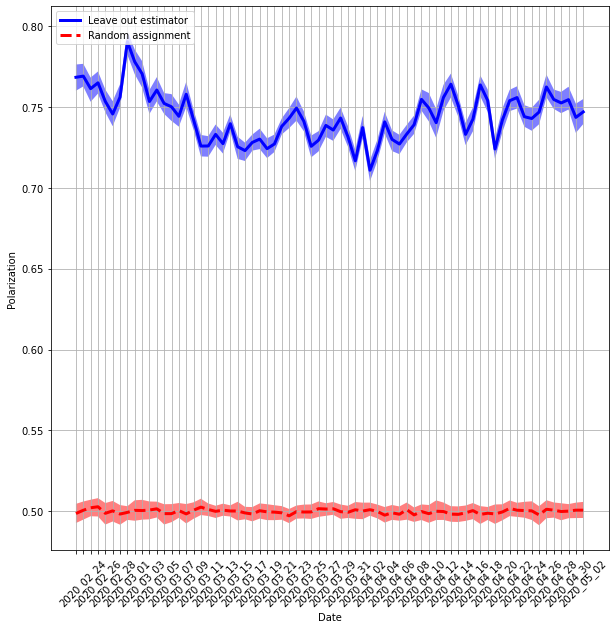

In [17]:
fig, ax = plt.subplots(1,figsize = (10,10))
ax.plot(date, stats['true']['estimates'], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date, stats['random']['estimates'], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date, stats['true']['upper_ci'], stats['true']['lower_ci'], facecolor='blue', alpha=0.5)
ax.fill_between(date, stats['random']['upper_ci'], stats['random']['lower_ci'], facecolor='red', alpha=0.5)
#ax.plot(np.unique(range(len(date))), np.poly1d(np.polyfit(range(len(date)), estimate, 1))(np.unique(range(len(date)))))
#ax.plot(np.unique(range(len(date))), np.poly1d(np.polyfit(range(len(date)), estimate_random, 1))(np.unique(range(len(date)))))
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()

## Only coronavirus content:

In [22]:
results = run_models(70, retweets = True, randomized = True, keyword = "korona", aggregate = True)

100%|██████████| 70/70 [27:53<00:00, 23.90s/it]


TypeError: Object of type int64 is not JSON serializable

In [26]:
date = results["date"]
stats = {"true":dict(), "random":dict()}
for type in stats:
    
    #sample sizes for each time step
    sample_sizes = np.array([elem['n']['government'] + elem['n']['opposition'] for elem in results[type]['leaveout']])
    subsample_sizes = np.array([[elem['n']['government'] + elem['n']['opposition'] for elem in t['samples']] for t in results[type]['leaveout']])

    #sample estimates for each time step
    sample_estimates = np.array([elem['point'] for elem in results[type]['leaveout']])
    subsample_estimates = np.array([[elem['point'] for elem in t['samples']] for t in results[type]['leaveout']])

    #Qkt - for each subsample at each timestep - deviation of subsample from the mean, normalized by sqrt of the subsample's SD
    Q_kt = np.sqrt(subsample_sizes) * (subsample_estimates - 0.01 * np.sum(subsample_estimates, axis = 1)[:,np.newaxis])

    #lower ci
    stats[type]['lower_ci'] = sample_estimates - np.partition(Q_kt, 90, axis = 1)[:,90]/np.sqrt(sample_sizes)
    
    #upper ci
    stats[type]['upper_ci'] = sample_estimates - np.partition(Q_kt, 10, axis = 1)[:,10]/np.sqrt(sample_sizes) 
    
    #estimates
    stats[type]['estimates'] = sample_estimates
    

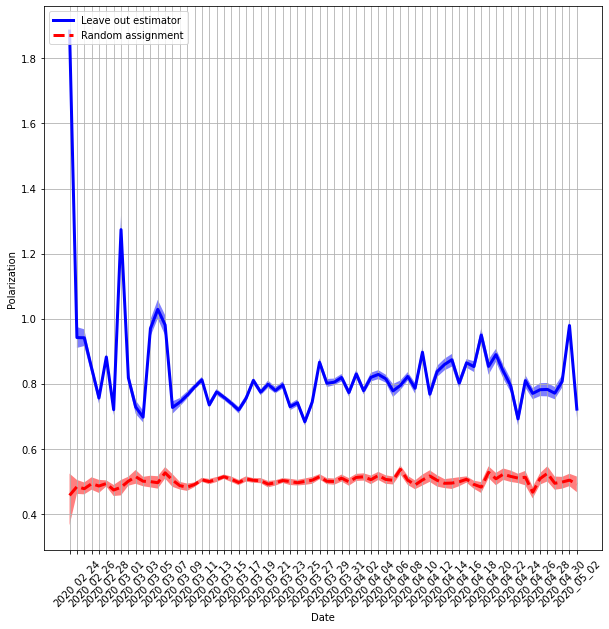

In [27]:
fig, ax = plt.subplots(1,figsize = (10,10))
ax.plot(date, stats['true']['estimates'], lw = 3, label='Leave out estimator', color='blue')
ax.plot(date, stats['random']['estimates'], lw = 3, linestyle = "--", label='Random assignment', color='red')
ax.fill_between(date, stats['true']['upper_ci'], stats['true']['lower_ci'], facecolor='blue', alpha=0.5)
ax.fill_between(date, stats['random']['upper_ci'], stats['random']['lower_ci'], facecolor='red', alpha=0.5)
#ax.plot(np.unique(range(len(date))), np.poly1d(np.polyfit(range(len(date)), estimate, 1))(np.unique(range(len(date)))))
#ax.plot(np.unique(range(len(date))), np.poly1d(np.polyfit(range(len(date)), estimate_random, 1))(np.unique(range(len(date)))))
ax.legend(loc='upper left')
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Polarization')
ax.grid()

## Distribution of disaggregated data:

Next look at the contribution of individual user scores:

In [48]:
res = run_models(10, retweets = False, randomized = False, conf_int = None, aggregate = False)

100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


In [52]:
keys = [key for elem in res['true']['leaveout'] for key in elem]
comp = dict().fromkeys(keys)
comp = {k:[] for k, v in comp.items()}
for elem in res['true']['leaveout']:
    for key in comp:
        if key in elem:
            comp[key].append(elem[key])
        else:
            comp[key].append(np.nan)

In [124]:
def interpolate_nan(array:np.ndarray):
    bad_index = np.isnan(array)
    good_index = np.logical_not(bad_index)
    bad_index = bad_index.nonzero()[0]
    good_index = good_index.nonzero()[0]
    bad_index = bad_index[bad_index < good_index.max() + 1]
    array_good = array[:good_index.max()+1]
    interpolated = np.interp(bad_index, good_index, array_good[good_index])
    array[bad_index] = interpolated
    return array

In [192]:
disaggregated = pd.DataFrame(comp).T.reset_index()
disaggregated.columns = ["source","id_str",*res["date"]]
#pivot longer:
disaggregated = pd.melt(disaggregated, id_vars = ["source","id_str"], value_vars = disaggregated.columns[2:])

In [206]:
gov = pd.read_csv("data/sample/gov_partisans_info.csv", index_col = 0)
gov["source"] = "government"
opp = pd.read_csv("data/sample/gov_partisans_info.csv", index_col = 0)
opp["source"] = "opposition"
info = pd.concat([gov, opp], axis = 0).reset_index()
del(gov, opp)
info = info[["followers_count", "id_str","source"]]

In [209]:
pd.merge(disaggregated, info, how = "left", on = ["source","id_str"])

,source,id_str,variable,value,followers_count
0,government,1001506051844395011,2020_02_23,0.411765,NaN
1,government,1004257000929288192,2020_02_23,0.375000,NaN
2,government,1010582612971327488,2020_02_23,0.702231,1068
3,government,1012058009638461440,2020_02_23,0.222222,NaN
4,government,1015885134397169664,2020_02_23,0.200000,NaN
5,government,1017158219003723777,2020_02_23,0.400000,4249
6,government,101889413,2020_02_23,0.321344,NaN
7,government,1021835515262365696,2020_02_23,0.629630,684
8,government,102964007,2020_02_23,0.956522,NaN
9,government,1030911624180314113,2020_02_23,0.428571,335
